# CAB420, DCNNs, Additional Script: Lots of VGG-Like Models
Dr Simon Denman (s.denman@qut.edu.au)

## What is this all about?

This is a script that will train, and save, a bunch of models on the datasets that we use most commonly in CAB420. A mix of models, all based around a VGG style, will be trained.

These will all utilise the a couple of functions to build the network for us, which has been inspired by the ResNet example. Basically, it made sense to do the same thing for VGG networks as was done for ResNet.

As per the ResNet example, results are shown for each model, but this is really just about training models for use later on. Networks of different levels of complexity (i.e. number of layers, numbers of filters) are trained to enable comparisson, but also to allow students to pick a network that suits the computational budget they have (i.e. if you have an old laptop, use a simpler model; if you have a GPU, you might want to use something bigger).

As per the ResNet exmaples, this was run on a GPU equipped desktop.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import datetime
import numpy

import keras
from keras import layers
from keras import activations

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint

## Network Building Functions
We'll set up a function or three to build the networks for us. We'll have:
* A function to build a convolution block. This is two 2D convolutions, each with 3x3 kernels and the same number of filters, followed by BatchNormalisation and optionally a spatial dropout and 2x2 max-pooling. We'll use this such that we always have a max-pool unless it's the last block
* A function to build a fully connected block. This will have a fully connected layer of specified size, a batch-norm, and then optionally dropout
* A function to build the network as a whole. This will take in an input layer, the list of filters sizes for the convolution blocks, list of fully connected layer sizes, spatial dropout rate, and dropout rate. This won't create an input or an output - that up to you when you call it.

In [2]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

## Model Training, Evaluation and Saving
Simple function to:
* Create a checkpoint to save the best weights
* Train the network
* Load the best model weights
* Save the whole model, architeture and best weights
* Plot the loss and accuracy grapsh
* Evaluate the best model on the training and testing sets

In [3]:
def train_and_eval(model, x_train, y_train, x_test, y_test, filename, batch_size, epochs, clear_when_done = True):
    
    # create model saving checkpoint
    checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

    # train model
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])    

    # load the best model for evaluation
    model.load_weights(filename)
    
    # print the training history
    fig = plt.figure(figsize=[30, 10])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Performance')

    # evaluate the model
    ax = fig.add_subplot(1, 3, 2)
    pred = model.predict(x_train, verbose=False);
    indexes = keras.ops.argmax(pred, axis=1)
    cm = confusion_matrix(y_train, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)    
    ax.set_title('Training')
    
    ax = fig.add_subplot(1, 3, 3)
    pred = model.predict(x_test, verbose=False);
    indexes = keras.ops.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)    
    ax.set_title('Testing')
    
    # clean up, free up memory
    if clear_when_done:
        keras.utils.clear_session()

## Some Global Constants
These are some constant values that we'll use in these models. Things like the batch size and number of epochs.

In [4]:
batch_size = 128;
num_epochs = 10;

## Fashion MNIST Models

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### VGG, 2 Stage, Small

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7639 - loss: 0.6716
Epoch 1: val_loss improved from inf to 0.45141, saving model to ../models/vgg_2stage_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.7640 - loss: 0.6712 - val_accuracy: 0.8230 - val_loss: 0.4514
Epoch 2/10
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8748 - loss: 0.3417
Epoch 2: val_loss improved from 0.45141 to 0.33140, saving model to ../models/vgg_2stage_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8749 - loss: 0.3416 - val_accuracy: 0.8693 - val_loss: 0.3314
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8870 - loss: 0.2999
Epoch 3: val_loss improved from 0.33140 to 0.29450, saving model to ../models/vgg_2stage_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8870 - loss: 0.2999 - val_accuracy: 0.8929 - val_loss: 0.2945
Epoch 4/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

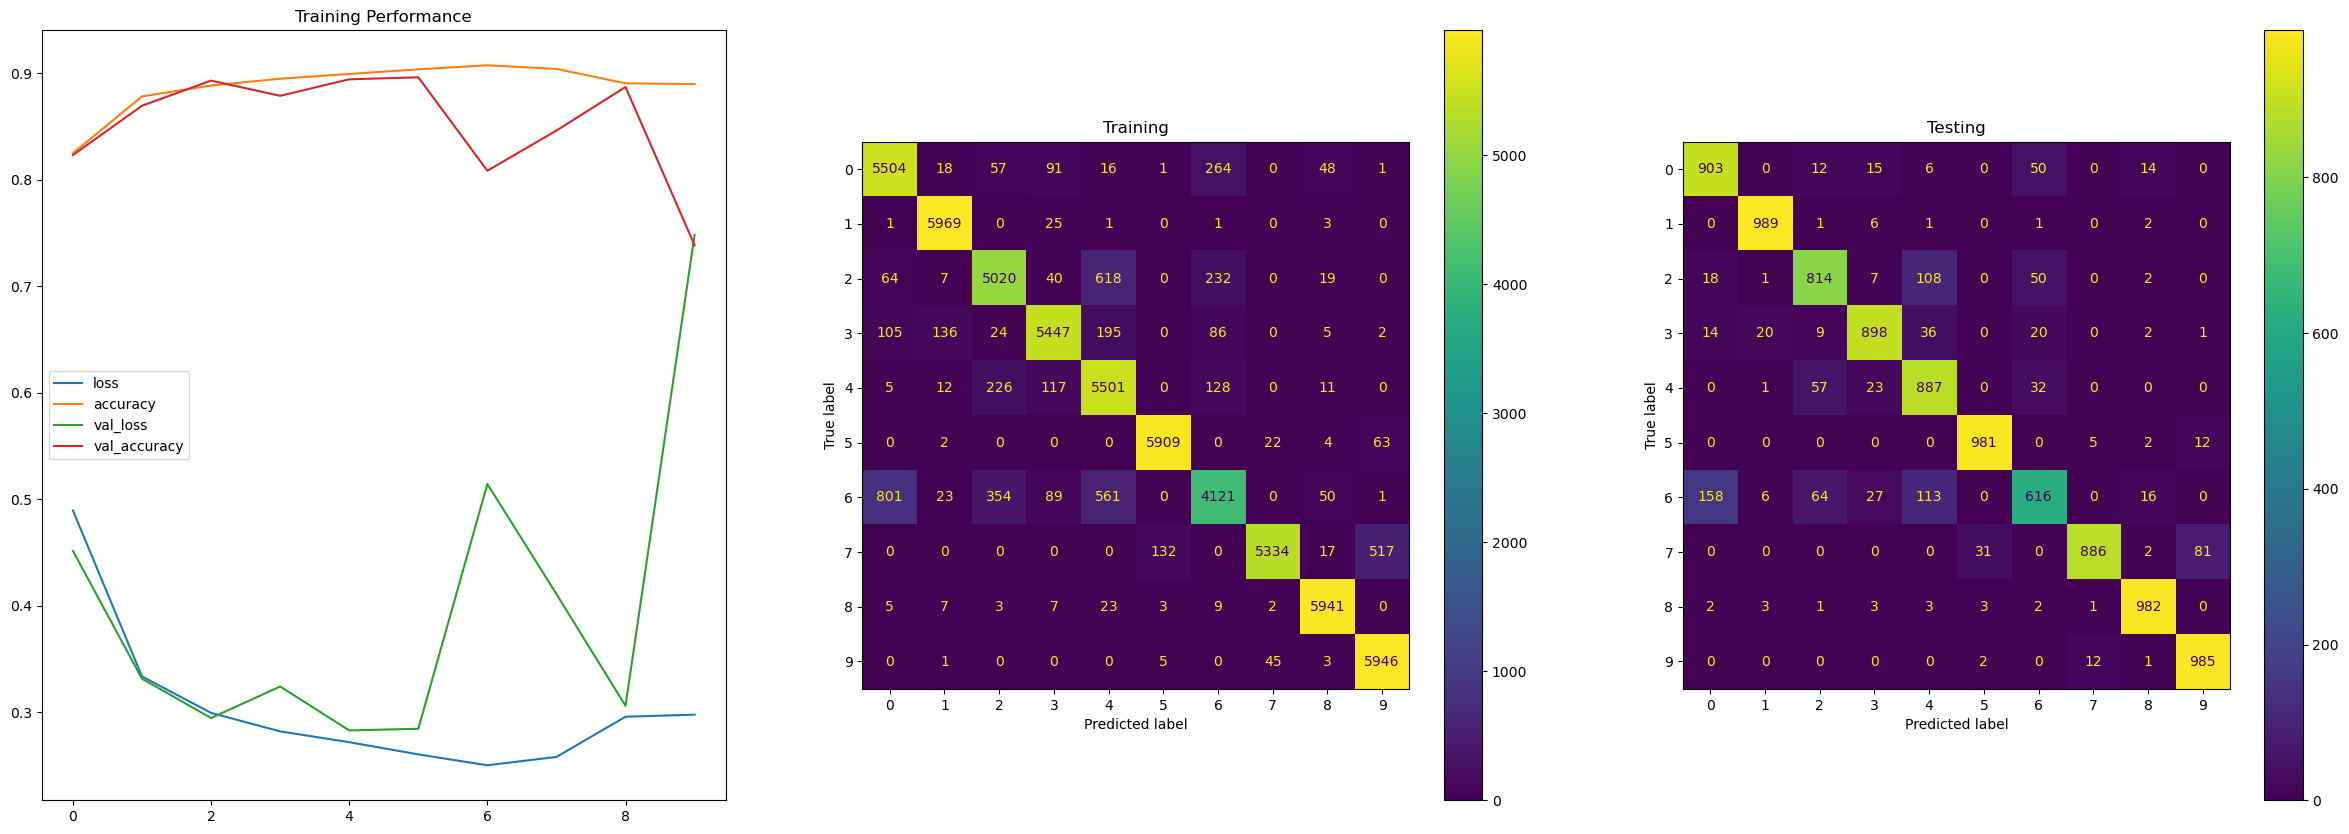

In [6]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [8, 16], [256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_2stage_FashionMNIST_small.keras', batch_size, num_epochs)

### VGG, 2 Stage, Bigger

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7913 - loss: 0.5861
Epoch 1: val_loss improved from inf to 0.35634, saving model to ../models/vgg_2stage_FashionMNIST_bigger.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7914 - loss: 0.5858 - val_accuracy: 0.8654 - val_loss: 0.3563
Epoch 2/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8813 - loss: 0.3197
Epoch 2: val_loss improved from 0.35634 to 0.29380, saving model to ../models/vgg_2stage_FashionMNIST_bigger.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8813 - loss: 0.3196 - val_accuracy: 0.8932 - val_loss: 0.2938
Epoch 3/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8956 - loss: 0.2814
Epoch 3: val_loss did not improve from 0.29380
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8956 - loss: 0.2814 - val_accuracy: 0.8844 - val_loss: 0.3057
Epoch 4/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9050 - loss: 0.2544
Epoch 4: val_loss did not im

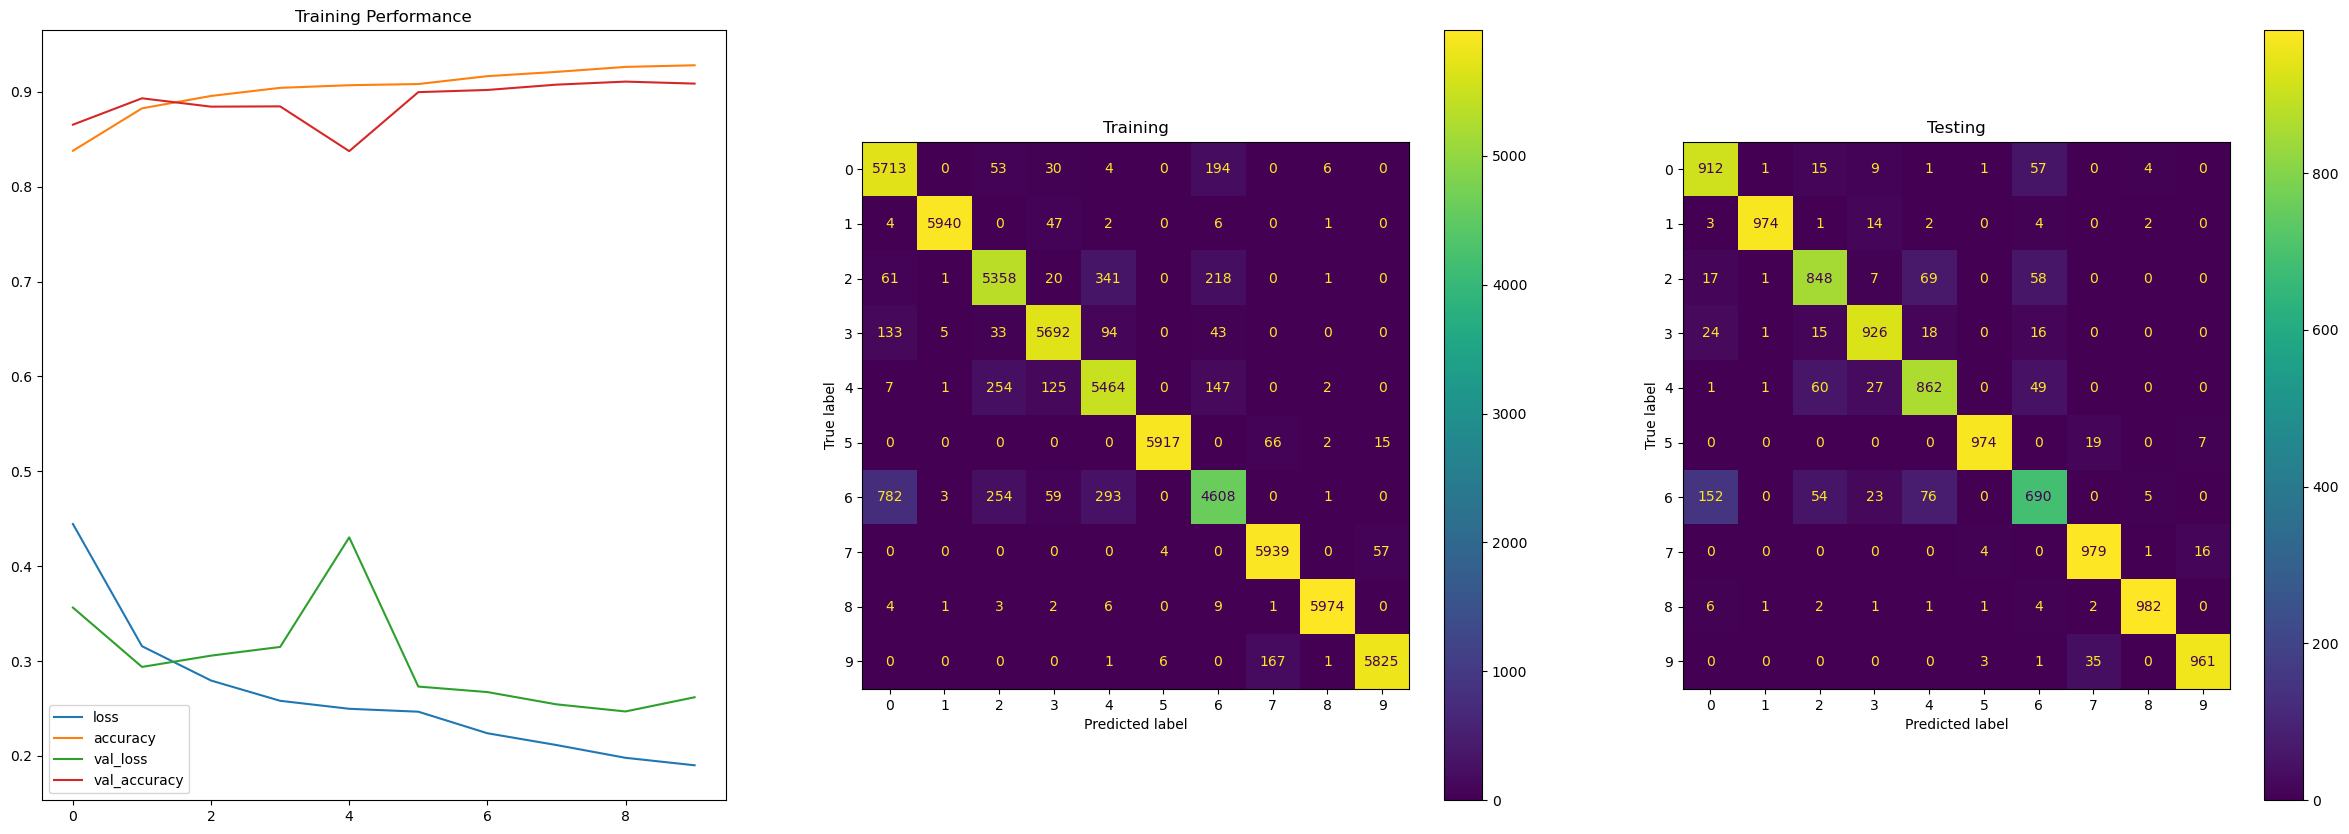

In [7]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_2stage_FashionMNIST_bigger.keras', batch_size, num_epochs)

### VGG, 3 Stage, Small

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7418 - loss: 0.7198
Epoch 1: val_loss improved from inf to 0.62692, saving model to ../models/vgg_3stage_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7419 - loss: 0.7195 - val_accuracy: 0.7407 - val_loss: 0.6269
Epoch 2/10
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8226 - loss: 0.4773
Epoch 2: val_loss improved from 0.62692 to 0.56450, saving model to ../models/vgg_3stage_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8227 - loss: 0.4769 - val_accuracy: 0.8012 - val_loss: 0.5645
Epoch 3/10
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8448 - loss: 0.4129
Epoch 3: val_loss improved from 0.56450 to 0.47888, saving model to ../models/vgg_3stage_FashionMNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8448 - loss: 0.4129 - val_accuracy: 0.8190 - val_loss: 0.4789
Epoch 4/10
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

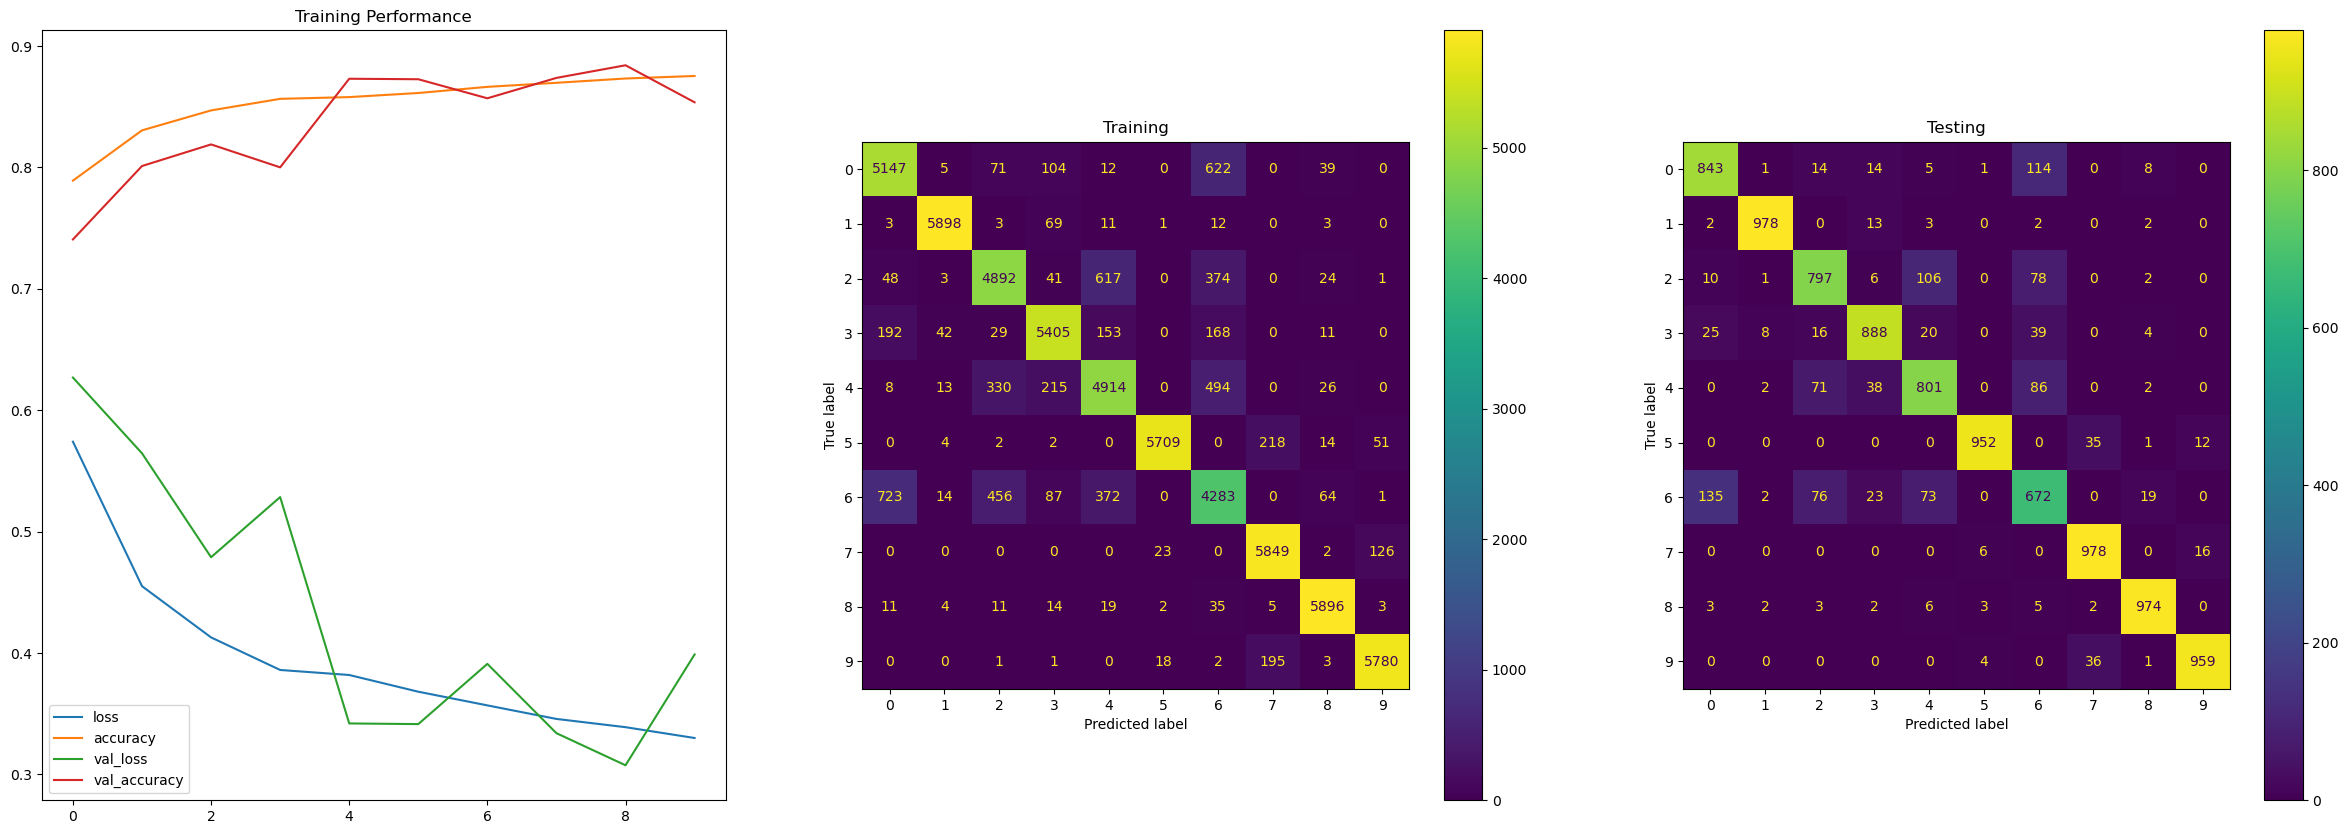

In [8]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [8, 16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_3stage_FashionMNIST_small.keras', batch_size, num_epochs)

### VGG, 3 Stage, Bigger

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7163 - loss: 0.7765
Epoch 1: val_loss improved from inf to 0.69055, saving model to ../models/vgg_3stage_FashionMNIST_bigger.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.7165 - loss: 0.7761 - val_accuracy: 0.7448 - val_loss: 0.6905
Epoch 2/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8414 - loss: 0.4275
Epoch 2: val_loss improved from 0.69055 to 0.53563, saving model to ../models/vgg_3stage_FashionMNIST_bigger.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8414 - loss: 0.4273 - val_accuracy: 0.7936 - val_loss: 0.5356
Epoch 3/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8553 - loss: 0.3895
Epoch 3: val_loss improved from 0.53563 to 0.47634, saving model to ../models/vgg_3stage_FashionMNIST_bigger.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8553 - loss: 0.3894 - val_accuracy: 0.8206 - val_loss: 0.4763
Epoch 4/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8m

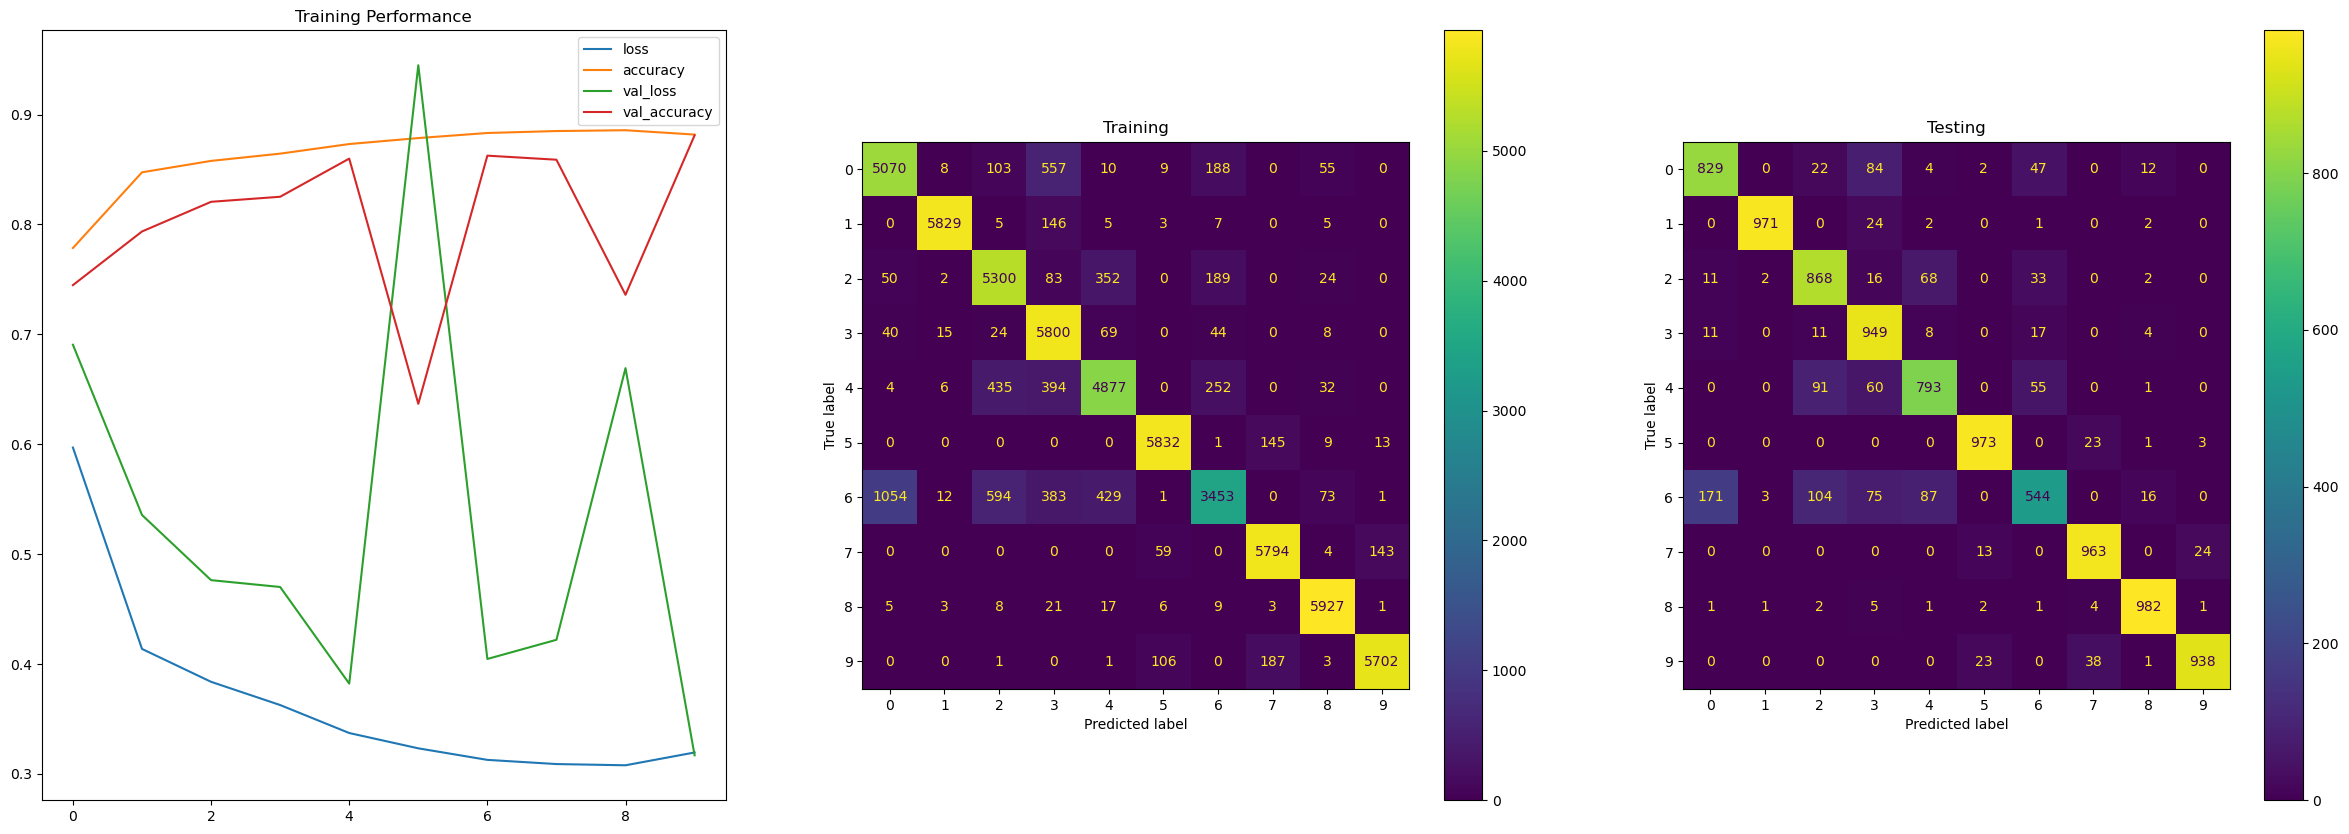

In [9]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [16, 32, 64], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_3stage_FashionMNIST_bigger.keras', batch_size, num_epochs)

## MNIST Models

In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### VGG, 2 Stage, Small

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8842 - loss: 0.3911
Epoch 1: val_loss improved from inf to 0.06566, saving model to ../models/vgg_2stage_MNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8843 - loss: 0.3907 - val_accuracy: 0.9787 - val_loss: 0.0657
Epoch 2/10
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.0815
Epoch 2: val_loss improved from 0.06566 to 0.06308, saving model to ../models/vgg_2stage_MNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9751 - loss: 0.0814 - val_accuracy: 0.9776 - val_loss: 0.0631
Epoch 3/10
457/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9810 - loss: 0.0602
Epoch 3: val_loss improved from 0.06308 to 0.03588, saving model to ../models/vgg_2stage_MNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9810 - loss: 0.0602 - val_accuracy: 0.9870 - val_loss: 0.0359
Epoch 4/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - 

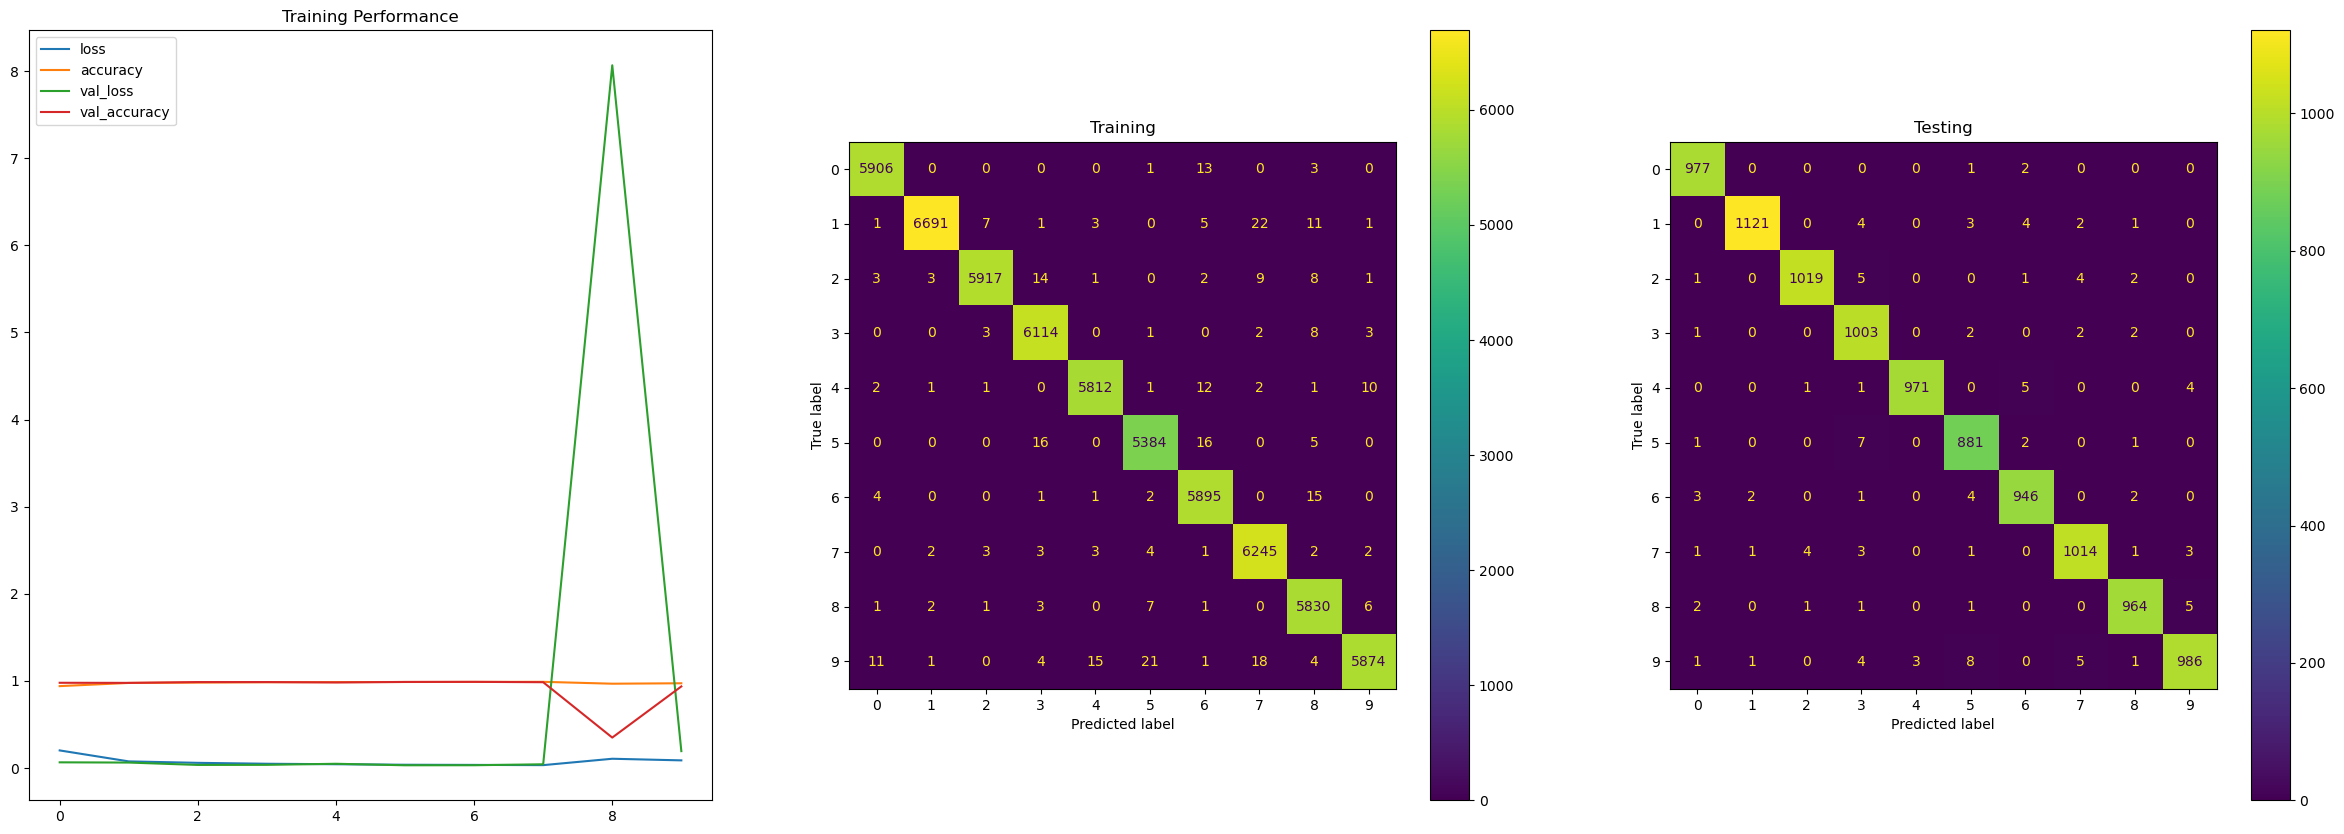

In [11]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [8, 16], [256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_2stage_MNIST_small.keras', batch_size, num_epochs)

### VGG, 2 Stage, Bigger

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9002 - loss: 0.3163
Epoch 1: val_loss improved from inf to 0.40535, saving model to ../models/vgg_2stage_MNIST_bigger.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9003 - loss: 0.3161 - val_accuracy: 0.8731 - val_loss: 0.4053
Epoch 2/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9699 - loss: 0.0960
Epoch 2: val_loss did not improve from 0.40535
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9700 - loss: 0.0960 - val_accuracy: 0.7386 - val_loss: 1.0963
Epoch 3/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9747 - loss: 0.0818
Epoch 3: val_loss improved from 0.40535 to 0.30438, saving model to ../models/vgg_2stage_MNIST_bigger.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9747 - loss: 0.0817 - val_accuracy: 0.9030 - val_loss: 0.3044
Epoch 4/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9776 - loss: 0.0713
Epoch 4: val_loss did not improve from 0.3

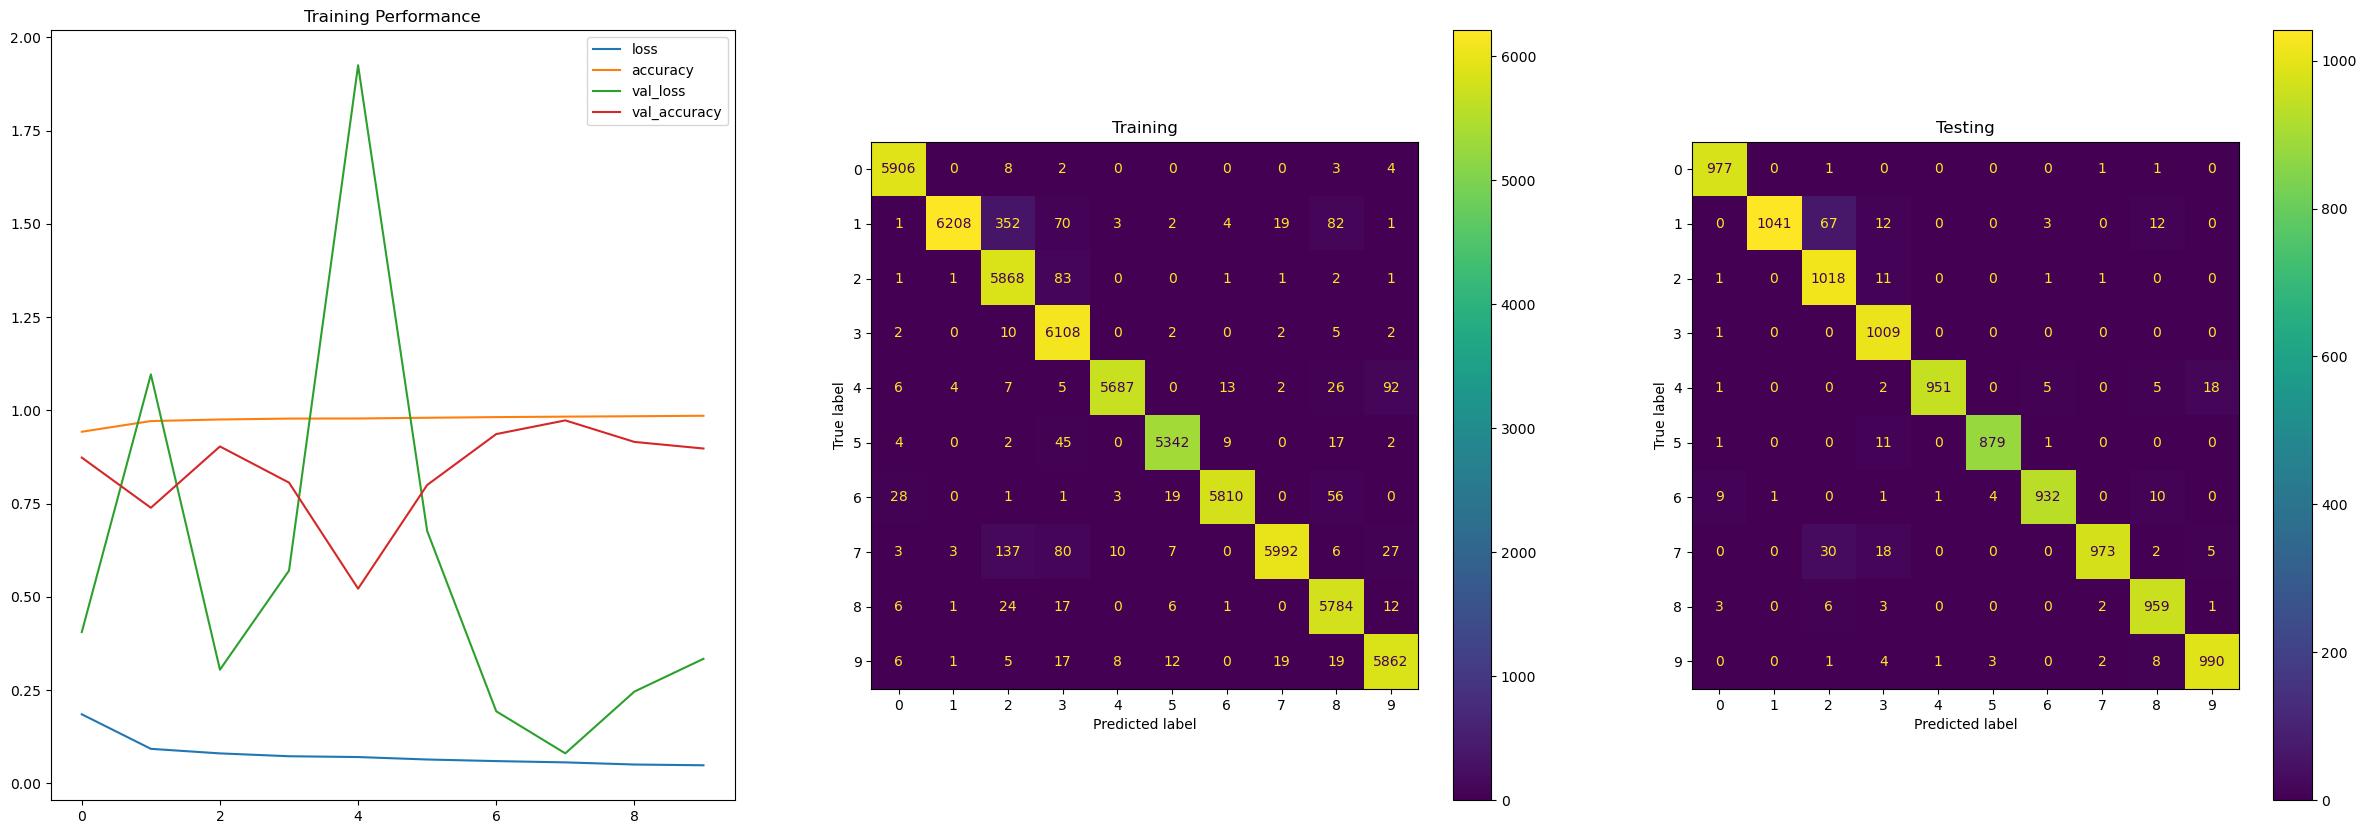

In [12]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_2stage_MNIST_bigger.keras', batch_size, num_epochs)

### VGG, 3 Stage, Small

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8597 - loss: 0.4433
Epoch 1: val_loss improved from inf to 0.05467, saving model to ../models/vgg_3stage_MNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8599 - loss: 0.4429 - val_accuracy: 0.9834 - val_loss: 0.0547
Epoch 2/10
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9724 - loss: 0.0909
Epoch 2: val_loss improved from 0.05467 to 0.04315, saving model to ../models/vgg_3stage_MNIST_small.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9725 - loss: 0.0907 - val_accuracy: 0.9876 - val_loss: 0.0431
Epoch 3/10
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9786 - loss: 0.0673
Epoch 3: val_loss did not improve from 0.04315
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9786 - loss: 0.0672 - val_accuracy: 0.9869 - val_loss: 0.0440
Epoch 4/10
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9823 - loss: 0.0546
Epoch 4: val_loss improved from 0.04315 to 0.

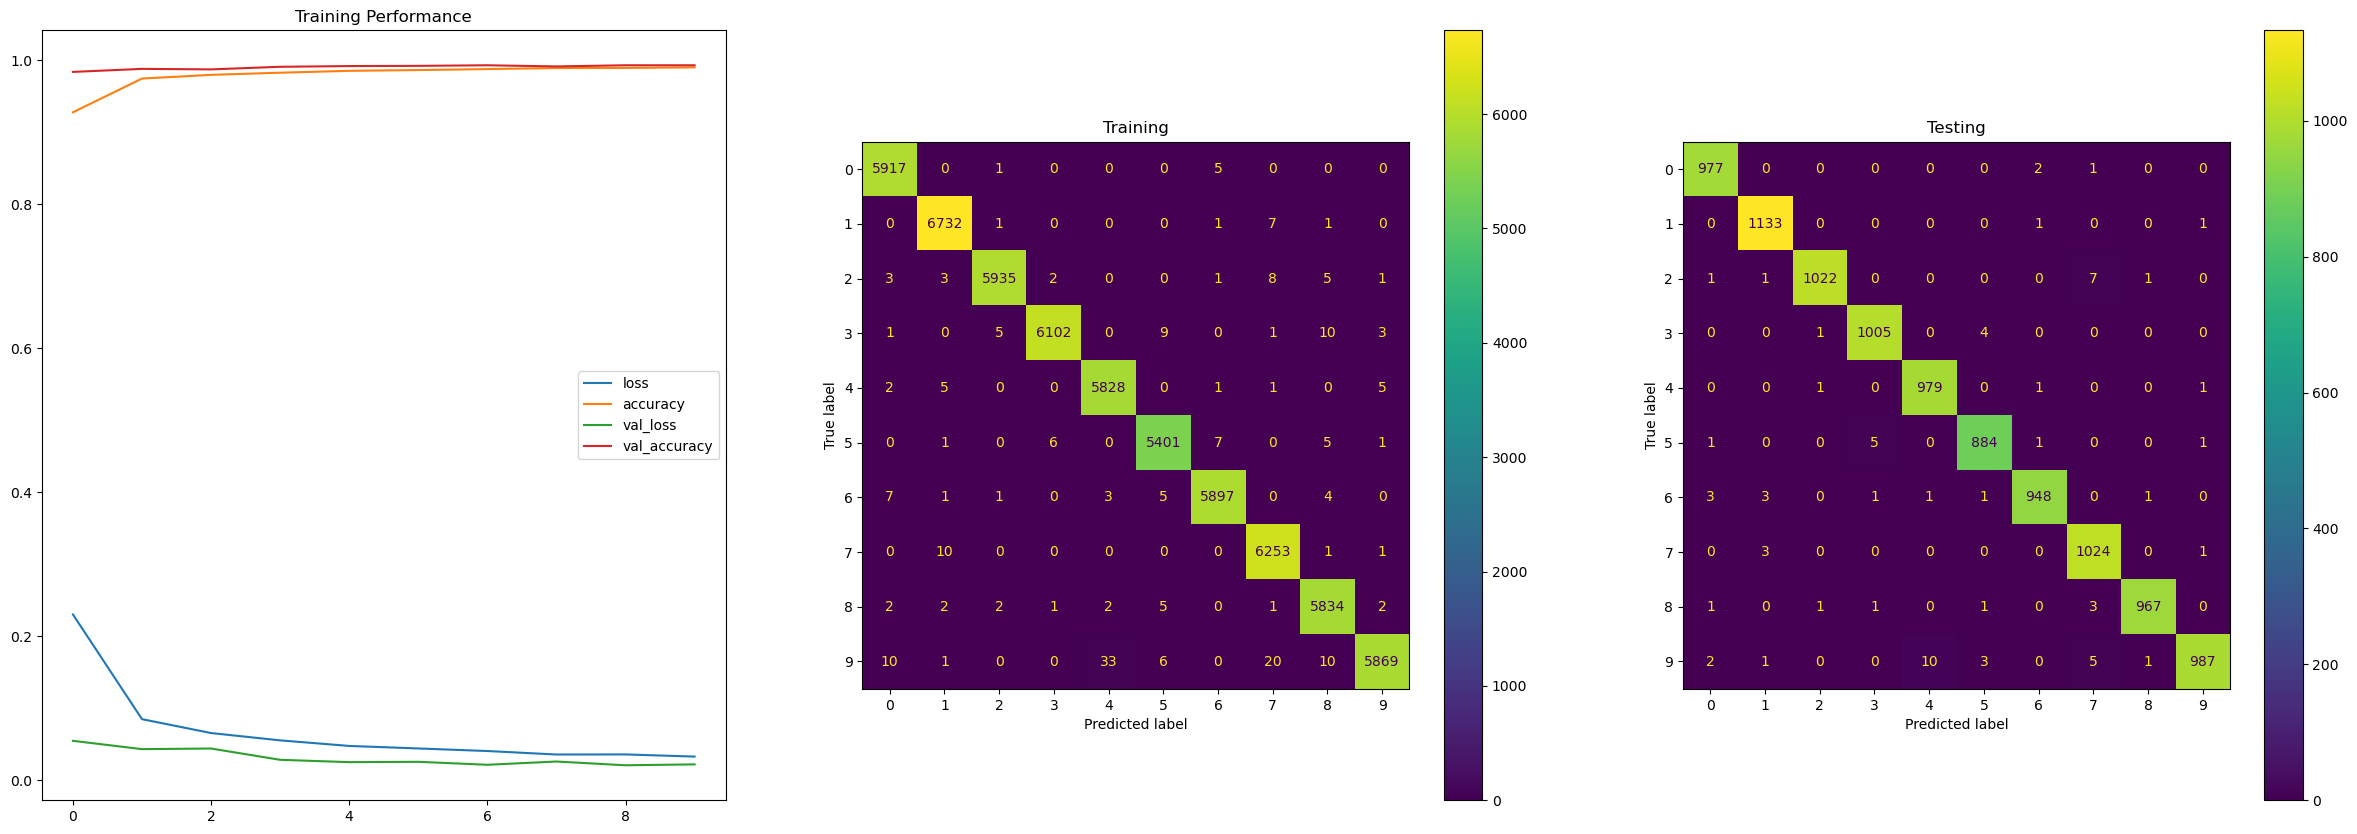

In [13]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [8, 16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_3stage_MNIST_small.keras', batch_size, num_epochs)

### VGG, 3 Stage, Bigger

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8757 - loss: 0.3901
Epoch 1: val_loss improved from inf to 0.08412, saving model to ../models/vgg_3stage_MNIST_bigger.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8758 - loss: 0.3897 - val_accuracy: 0.9708 - val_loss: 0.0841
Epoch 2/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9713 - loss: 0.0926
Epoch 2: val_loss did not improve from 0.08412
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9713 - loss: 0.0925 - val_accuracy: 0.9476 - val_loss: 0.1681
Epoch 3/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9781 - loss: 0.0696
Epoch 3: val_loss improved from 0.08412 to 0.06053, saving model to ../models/vgg_3stage_MNIST_bigger.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9781 - loss: 0.0696 - val_accuracy: 0.9806 - val_loss: 0.0605
Epoch 4/10
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9831 - loss: 0.0537
Epoch 4: val_loss improved from 0.06053 to

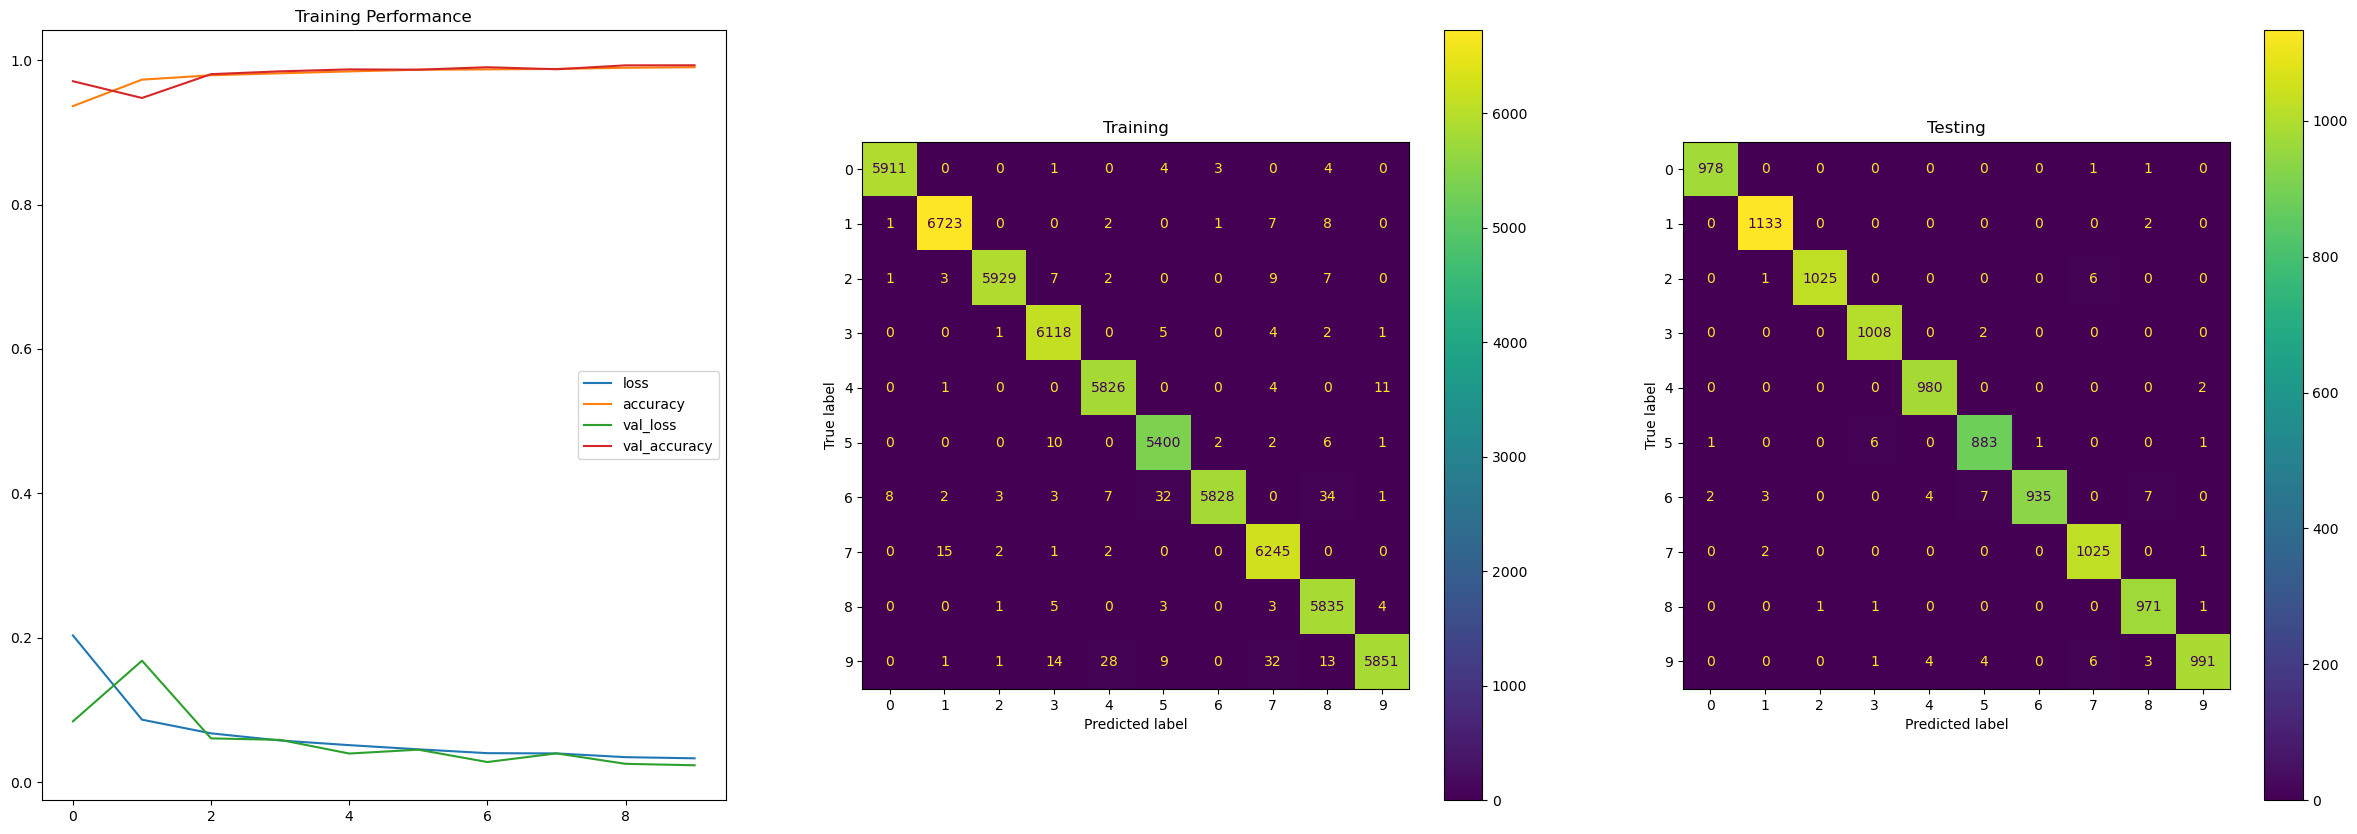

In [14]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [16, 32, 64], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_3stage_MNIST_bigger.keras', batch_size, num_epochs)

## CIFAR-10 Models

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3) / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3) / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### VGG, 2 Stage, Small

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3134 - loss: 1.9494
Epoch 1: val_loss improved from inf to 1.52094, saving model to ../models/vgg_2stage_CIFAR_small.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.3135 - loss: 1.9490 - val_accuracy: 0.4475 - val_loss: 1.5209
Epoch 2/10
381/391 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4363 - loss: 1.5506
Epoch 2: val_loss did not improve from 1.52094
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4365 - loss: 1.5499 - val_accuracy: 0.4107 - val_loss: 1.5857
Epoch 3/10
382/391 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4685 - loss: 1.4604
Epoch 3: val_loss did not improve from 1.52094
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4687 - loss: 1.4601 - val_accuracy: 0.2560 - val_loss: 2.4893
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4919 - loss: 1.4082
Epoch 4: val_loss did not improve from 1.52094
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.491

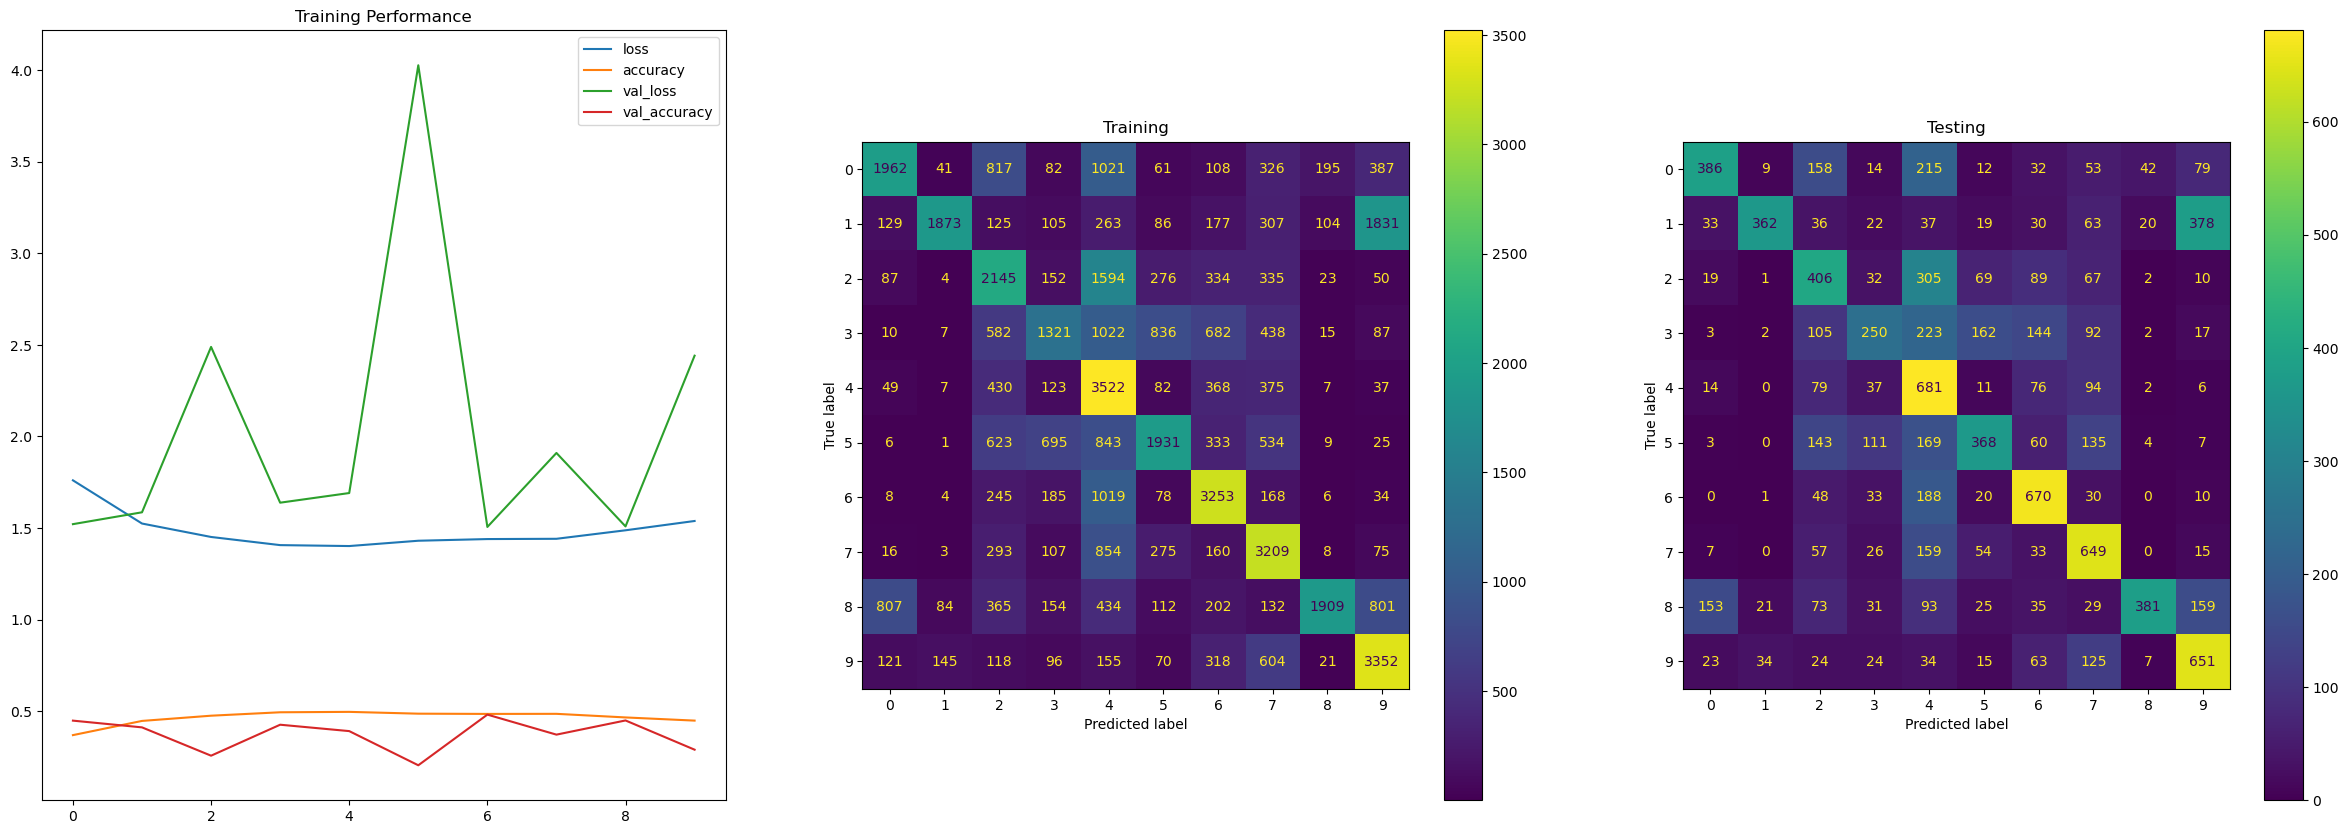

In [16]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [8, 16], [256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_2stage_CIFAR_small.keras', batch_size, num_epochs)

### VGG, 2 Stage, Bigger

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2745 - loss: 2.0430
Epoch 1: val_loss improved from inf to 4.30853, saving model to ../models/vgg_2stage_CIFAR_bigger.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.2746 - loss: 2.0426 - val_accuracy: 0.1503 - val_loss: 4.3085
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3544 - loss: 1.7769
Epoch 2: val_loss did not improve from 4.30853
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3544 - loss: 1.7768 - val_accuracy: 0.1399 - val_loss: 5.8167
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3843 - loss: 1.6808
Epoch 3: val_loss improved from 4.30853 to 1.81318, saving model to ../models/vgg_2stage_CIFAR_bigger.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3843 - loss: 1.6807 - val_accuracy: 0.3367 - val_loss: 1.8132
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4210 - loss: 1.5986
Epoch 4: val_loss improved from 1.81318 t

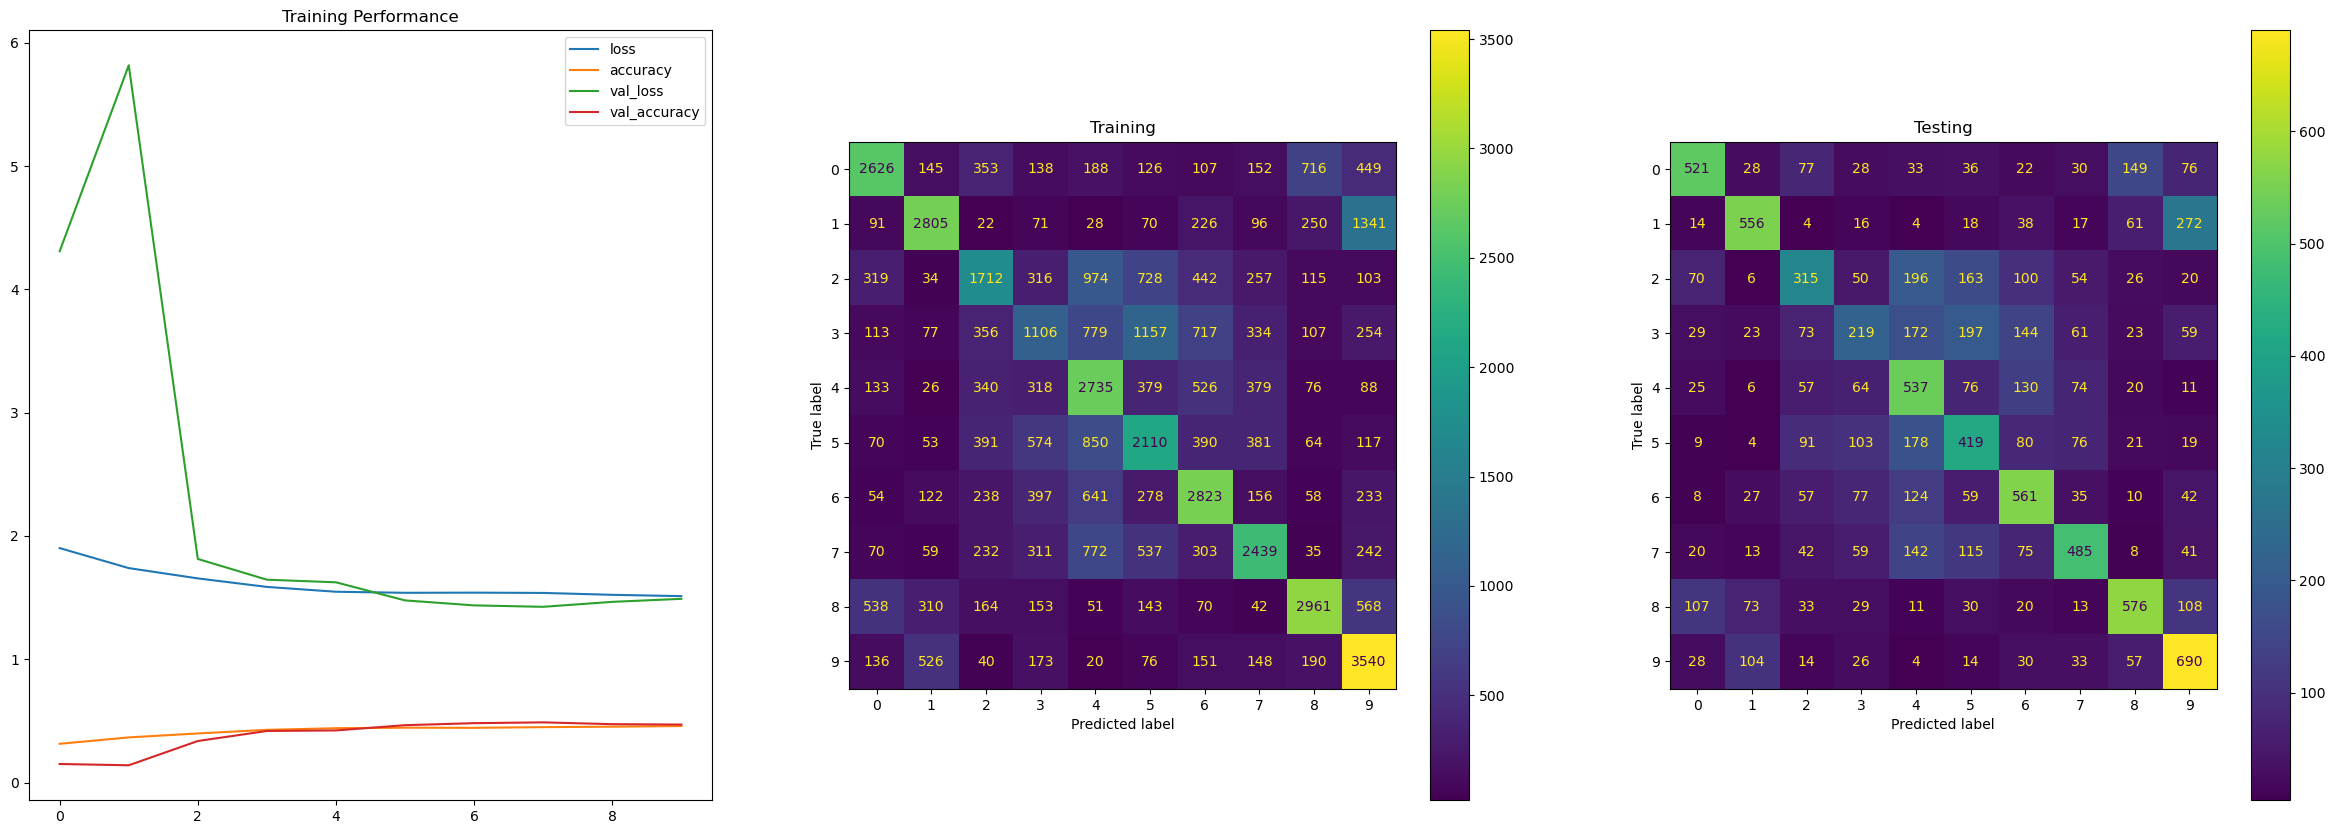

In [17]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_2stage_CIFAR_bigger.keras', batch_size, num_epochs)

### VGG, 3 Stage, Small

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2657 - loss: 2.0545
Epoch 1: val_loss improved from inf to 1.90360, saving model to ../models/vgg_3stage_CIFAR_small.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.2658 - loss: 2.0541 - val_accuracy: 0.2861 - val_loss: 1.9036
Epoch 2/10
385/391 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3685 - loss: 1.7166
Epoch 2: val_loss did not improve from 1.90360
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3685 - loss: 1.7166 - val_accuracy: 0.2124 - val_loss: 2.9234
Epoch 3/10
385/391 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3820 - loss: 1.6965
Epoch 3: val_loss improved from 1.90360 to 1.69188, saving model to ../models/vgg_3stage_CIFAR_small.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3821 - loss: 1.6962 - val_accuracy: 0.3692 - val_loss: 1.6919
Epoch 4/10
385/391 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4024 - loss: 1.6406
Epoch 4: val_loss improved from 1.69188 to 1.

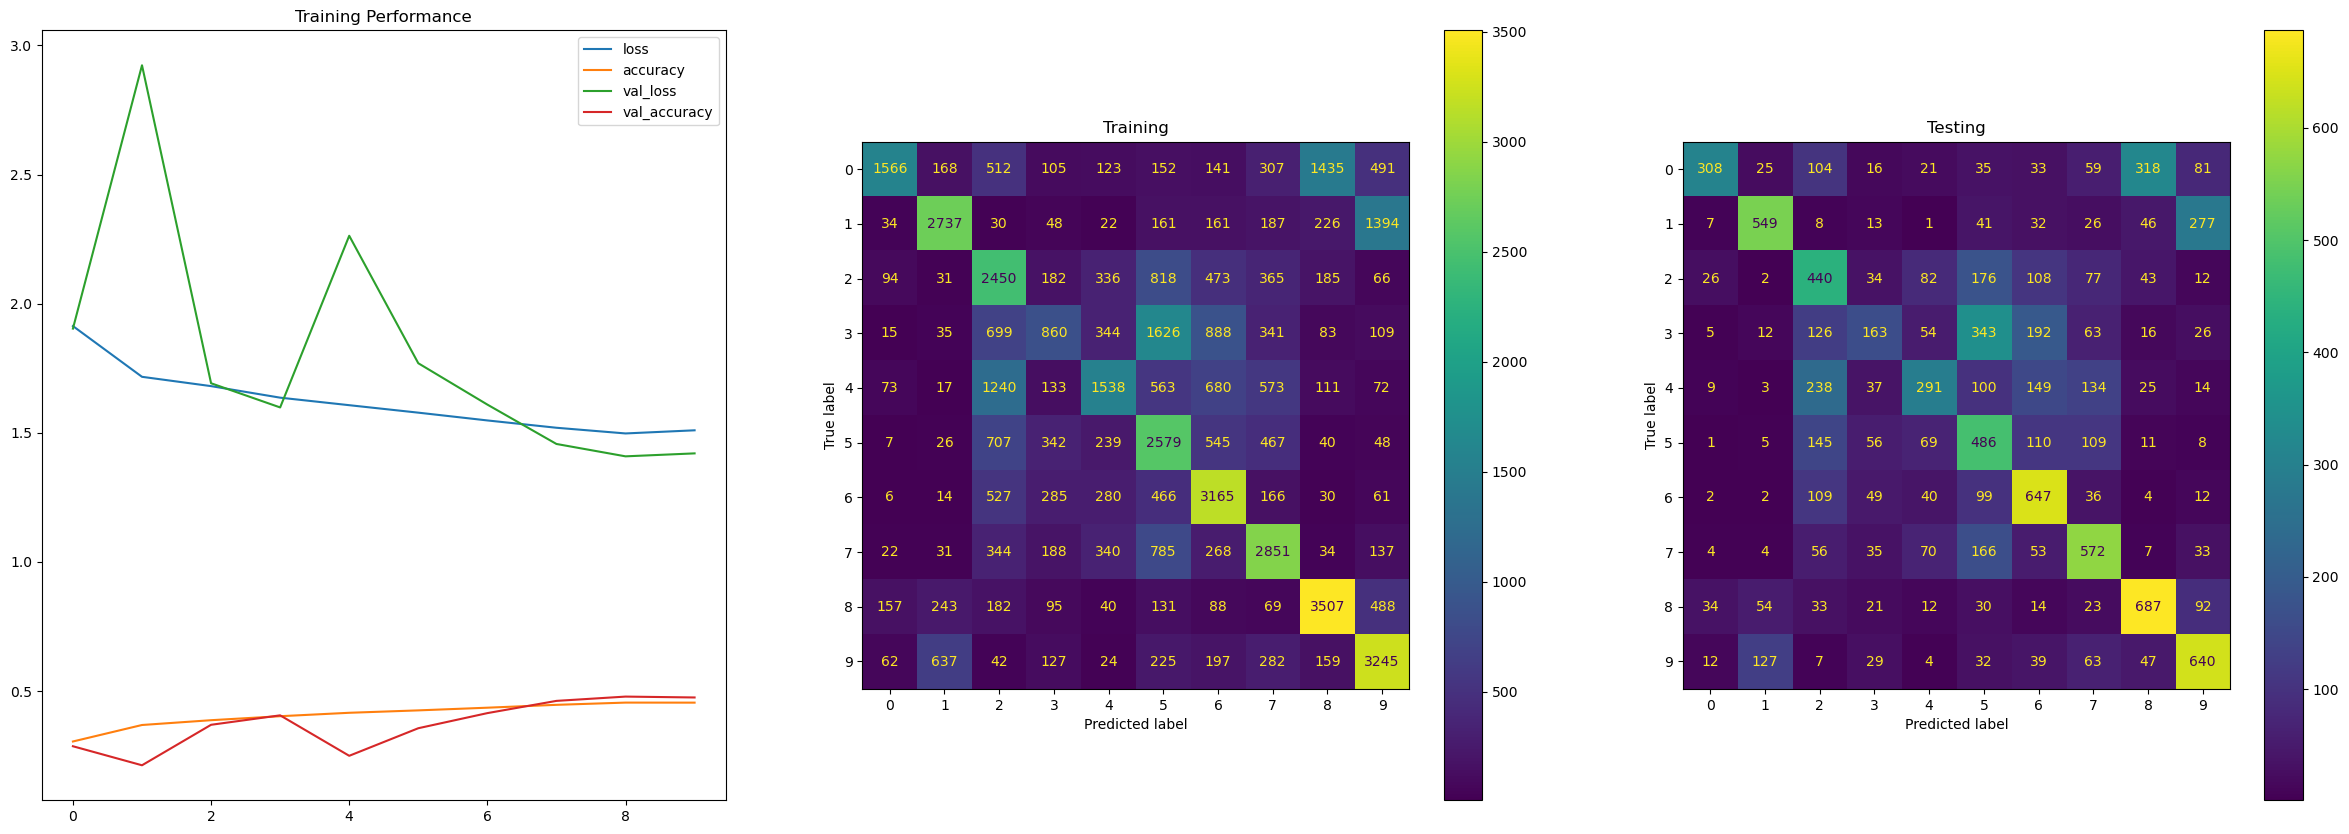

In [18]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [8, 16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_3stage_CIFAR_small.keras', batch_size, num_epochs)

### VGG, 3 Stage, Bigger

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2371 - loss: 2.1127
Epoch 1: val_loss improved from inf to 1.94098, saving model to ../models/vgg_3stage_CIFAR_bigger.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.2372 - loss: 2.1123 - val_accuracy: 0.2756 - val_loss: 1.9410
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3437 - loss: 1.7607
Epoch 2: val_loss did not improve from 1.94098
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3437 - loss: 1.7607 - val_accuracy: 0.1865 - val_loss: 5.0638
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3566 - loss: 1.7364
Epoch 3: val_loss improved from 1.94098 to 1.85514, saving model to ../models/vgg_3stage_CIFAR_bigger.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3566 - loss: 1.7364 - val_accuracy: 0.3147 - val_loss: 1.8551
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3801 - loss: 1.6774
Epoch 4: val_loss did not improve from

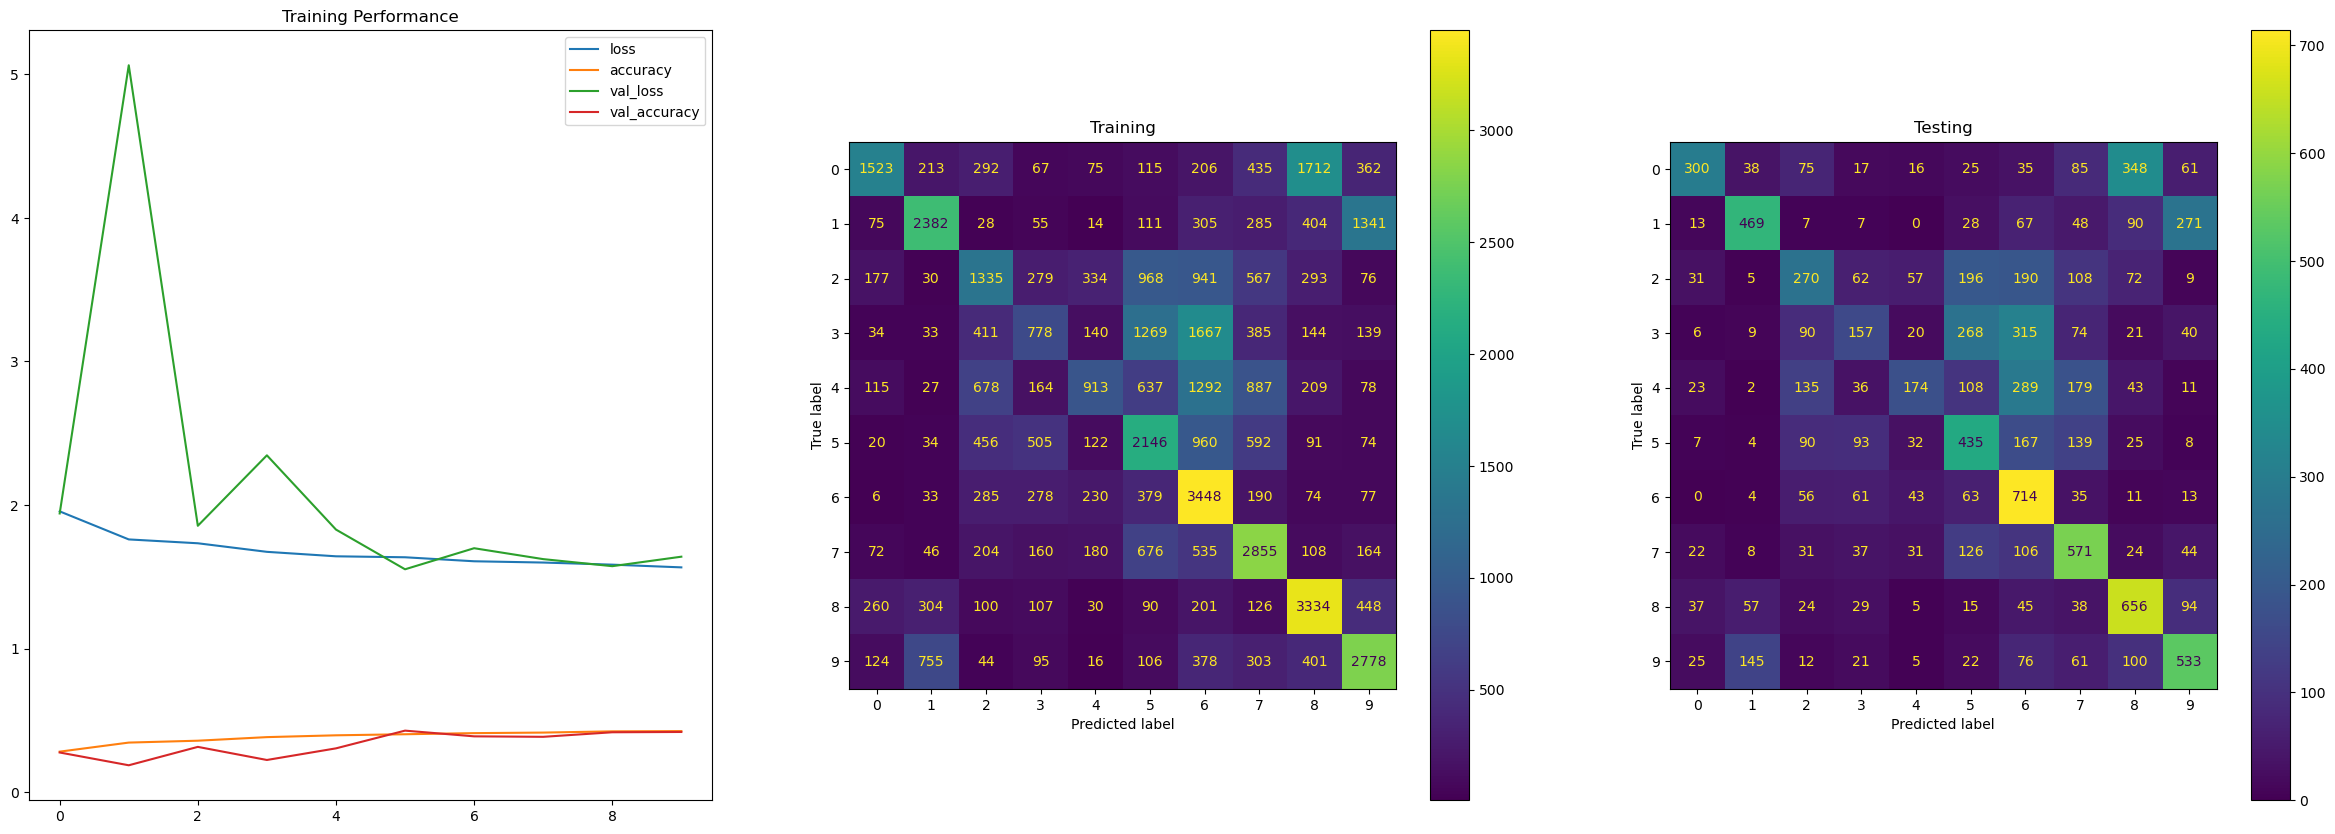

In [19]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16, 32, 64], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, '../models/vgg_3stage_CIFAR_bigger.keras', batch_size, num_epochs)

## Final Thoughts
Aa per the ResNet version, this is not really about explanations, but just running stuff. All the same, some thoughts on results follow:
* As we often see, performance is very high on MNIST and Fashion MNIST, and a bit less of CIFAR
* Performance does not drop off in a linear way with complexity. The difference between the smallest/simplest network and the best is not that great
* For the simpler tasks (Fashion MNIST and MNIST) performance is as good as or better than the more complex (and slower) resnet models. This is not the case for CIFAR though. As such, for many small tasks these models are probably sufficient. For ResNet in general, we're not really getting to the depths where we get a big benefit from that. The networks here and the networks in the ResNet example are fairly shallow by current standards. As such the use of skip connections to increase depth is not really needed, and the benefit from this is not observed. 
* Looking at runtimes between this and the ResNet examples, these are much quicker, even for the more complex models

As is often the case in this subject, we're not trying to get the best results possible. These models aren't as complex as they could be, but making them bigger and bigger makes them less and less practical - so we stop before things to get too big and slow.